In [2]:
##### Import Libraries
import pandas as pd
import glob
import matplotlib.pyplot as plt
import skimage
import numpy as np
import scipy.optimize

In [3]:
##### Open and Normalise the Slices in the Z-Stack 
# (normalise full stack between 0 and 500)

ImageStack = np.load('LEDArray_Intensity2DSlices.npy')

MaxOfImageStack = np.max(ImageStack)
MinOfImageStack = np.min(ImageStack)

ZStack = []       
for i in range(0,20):
    ImageNorm = (ImageStack[i] - MinOfImageStack)/(MaxOfImageStack - MinOfImageStack)
    ZStack.append(ImageNorm*500)

Done


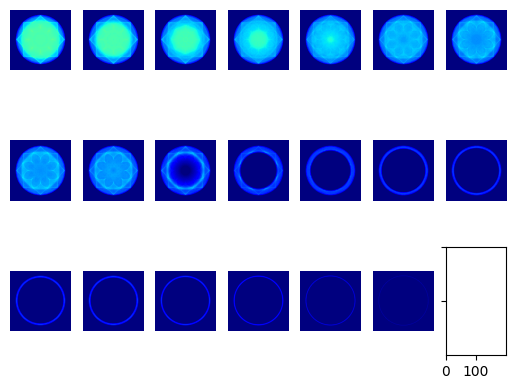

In [4]:
##### Display Slices in Z-Stack
fig, ax = plt.subplots(3, 7, sharex='col', sharey='row')


ImageCount = 0
for i in range(3):
    for j in range(7):
        try:
            ax[i][j].imshow(ZStack[ImageCount], vmin=0, vmax=1000, cmap='jet', aspect='auto')
            ax[i][j].set_aspect('equal')
            ax[i][j].axis('off')
            ImageCount += 1
        except:
            print("Done")

(-0.5, 199.5, 199.5, -0.5)

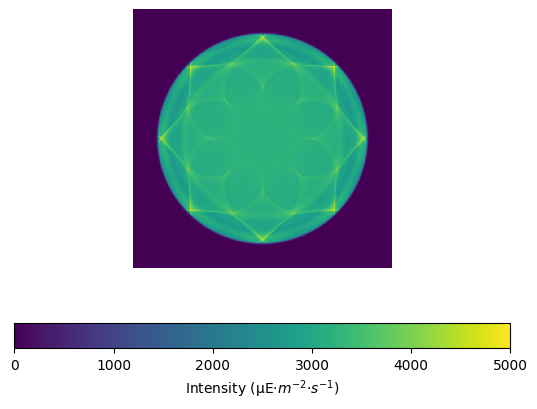

In [5]:
##### Display Result When We Simply Add All Slices Together
AddedImage = ZStack[0]

for s in range(1,20):
    AddedImage = AddedImage + ZStack[s]

plt.figure()
plt.imshow(AddedImage, vmin = 0, vmax = 5000, aspect='equal')
plt.colorbar(orientation='horizontal', label = 'Intensity (μE⋅$m^{{-2}}$⋅$s^{{-1}}$)')
plt.axis('off')

In [6]:
##### Create exponential curve data for each pixel of each z-slice

def Fluoresence(Finf, A, sigma, Int, t):
    return Finf + A * Int * np.exp(-(sigma)*(Int/1e6)*t)

# Define linespace
XValues = np.linspace(0,300,500)

# Define Parameters for the Curves (A and Finf can be fixed)
A = 0.1
Finf = 0
sigma = 198

# Get numbers of rows and columns
r,c = ZStack[0].shape

FlurescenceCurves = np.zeros((c,r,20,500))

# Create Curves
for i in range(0,200):
    for j in range(0,200):
        for s in range(20):
            FlurescenceCurves[i][j][s] = Fluoresence(Finf, A, sigma, ZStack[s][i][j], XValues)
            
    print(i)
    
    
print("Done")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Done


Done


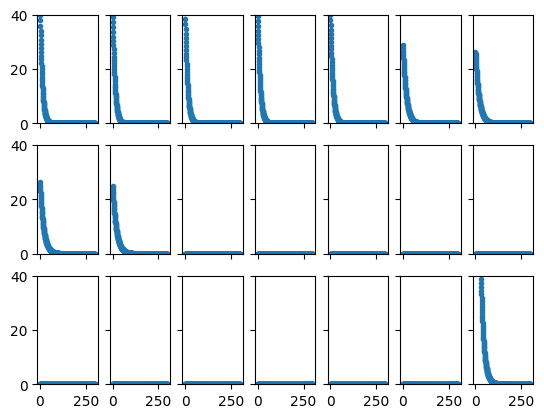

In [7]:
##### Add the curves together for each pixel
FluorescenceCurvesAdded = np.zeros((c,r,500))

for i in range(0,200):
    for j in range(0,200):
        FluorescenceCurvesAdded[i][j] = np.sum(FlurescenceCurves[i][j], axis=0)


# Display Curves for Add Slices for the Centre Pixel, and the Added Curve for That Pixel
fig, ax = plt.subplots(3, 7, sharex='col', sharey='row')

ImageCount = 0
Tally = 0
for i in range(3):
    for j in range(7):
        try:
            ax[i][j].set_ylim([0, 40])
            ax[i][j].plot(XValues, FlurescenceCurves[100][100][ImageCount], '.', label="data")
            Tally = Tally + FlurescenceCurves[100][100][ImageCount][0]
            ImageCount += 1
            
        except:
            print("Done")
        
ax[2][6].plot(XValues, FluorescenceCurvesAdded[100][100], '.', label="data")

In [9]:
##### Get the Tau values for the added curves

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b


TauMap = np.zeros((c,r,1))
RSquaredValues = np.zeros((c,r,1))

## Dont Try to Fit to Data Where There Was Barely A Decrease In Intensity (Less than 10% from start to finish)
DiffThresh = (FluorescenceCurvesAdded[100][100][0]-FluorescenceCurvesAdded[100][100][-1])*0.1

for i in range(0,200):
    for j in range(0,200):
        if ((FluorescenceCurvesAdded[i][j][0])-(FluorescenceCurvesAdded[i][j][-1])>DiffThresh):
            p0 = (255, 0.237, 10) # start with values near those we expect
            params, cv = scipy.optimize.curve_fit(monoExp, XValues[:], FluorescenceCurvesAdded[i][j][:], p0)
            m, t, b = params

            squaredDiffs = np.square(FluorescenceCurvesAdded[i][j][:] - monoExp(XValues[:], m, t, b))
            squaredDiffsFromMean = np.square(FluorescenceCurvesAdded[i][j][:] - np.mean(FluorescenceCurvesAdded[i][j][:]))
            RSquaredValue = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            
            if(RSquaredValue>0.99): # Only accept data where fit had R^2 over 0.99
                TauMap[i][j] = 1/t
                RSquaredValues[i][j] = RSquaredValue
        else:
            TauMap[i][j] = 10000
    print(i)
              
print(np.max(RSquaredValues))
print(np.min(RSquaredValues))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.9999987845474968
0.0


(-0.5, 199.5, 199.5, -0.5)

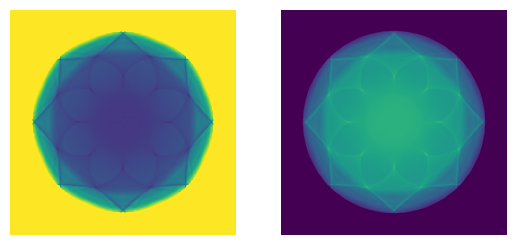

In [10]:
##### Display the Tau and Intensity Maps
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')

ax[0].imshow(TauMap, vmin=10, vmax = 35)
ax[0].axis('off')

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

I_480 = 1e6*(1/TauMap - tau_relax)/sigma_480

ax[1].imshow(I_480, vmin=0, vmax=450)
ax[1].axis('off')